<h1><center>Laboratorio 9: Optimización de modelos 💯</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: FELIPE GALAZ GARCÍA
- Nombre de alumno 2: MIRKO MARTINIC JARA


## Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.

## Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer material del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a técnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se irá optimizando.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

### **Link de repositorio de GitHub:** `https://github.com/mmartinicj/MDS7202-labs`

# Importamos librerias útiles

In [42]:
!pip install -qq xgboost optuna

In [43]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import pickle
import optuna
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback

# Pre-procesamiento
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Metricas de evaluación
from sklearn.metrics import mean_absolute_error

#Libreria para plotear
import seaborn as sns
from matplotlib import pyplot as plt
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

# librería para suprimir futureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Como usted tuvo un rendimiento sobresaliente en el proyecto de caracterización de datos, Fiu lo contrata como *data scientist* de su emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [44]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('Lab_09/sales.csv')
df['date'] = pd.to_datetime(df['date'])

df.head()

C:\Users\mirko\AppData\Local\Temp\ipykernel_21184\827143837.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


## 1.1 Generando un Baseline (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. [X] Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad.
2. [X] Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas.
3. [X] Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas.
4. [X] Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios.
5. [X] Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio?
6. [X] Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`?
7. [X] Guarde ambos modelos en un archivo .pkl (uno cada uno)

,count,mean,min,25%,50%,75%,max,std
id,7456.0,3784.92677,0.0,1889.75,3783.5,5682.25,7559.0,2185.822361
date,7456,2015-07-18 02:48:24.721029888,2012-01-31 00:00:00,2013-10-23 06:00:00,2015-07-31 00:00:00,2017-04-30 00:00:00,2018-12-31 00:00:00,NaN
lat,7456.0,38.300616,35.32787,37.96245,38.24444,39.63689,40.64361,1.65003
long,7456.0,23.27017,21.73444,22.41761,22.93086,23.71622,25.14341,1.086592
pop,7456.0,355042.733637,134219.0,141732.0,257501.5,665102.0,672130.0,232336.70302
price,7456.0,1.197193,0.11,0.62,0.93,1.51,4.79,0.818175
quantity,7456.0,29408.42838,2953.0,16572.75,25294.5,37699.0,145287.0,17652.985675


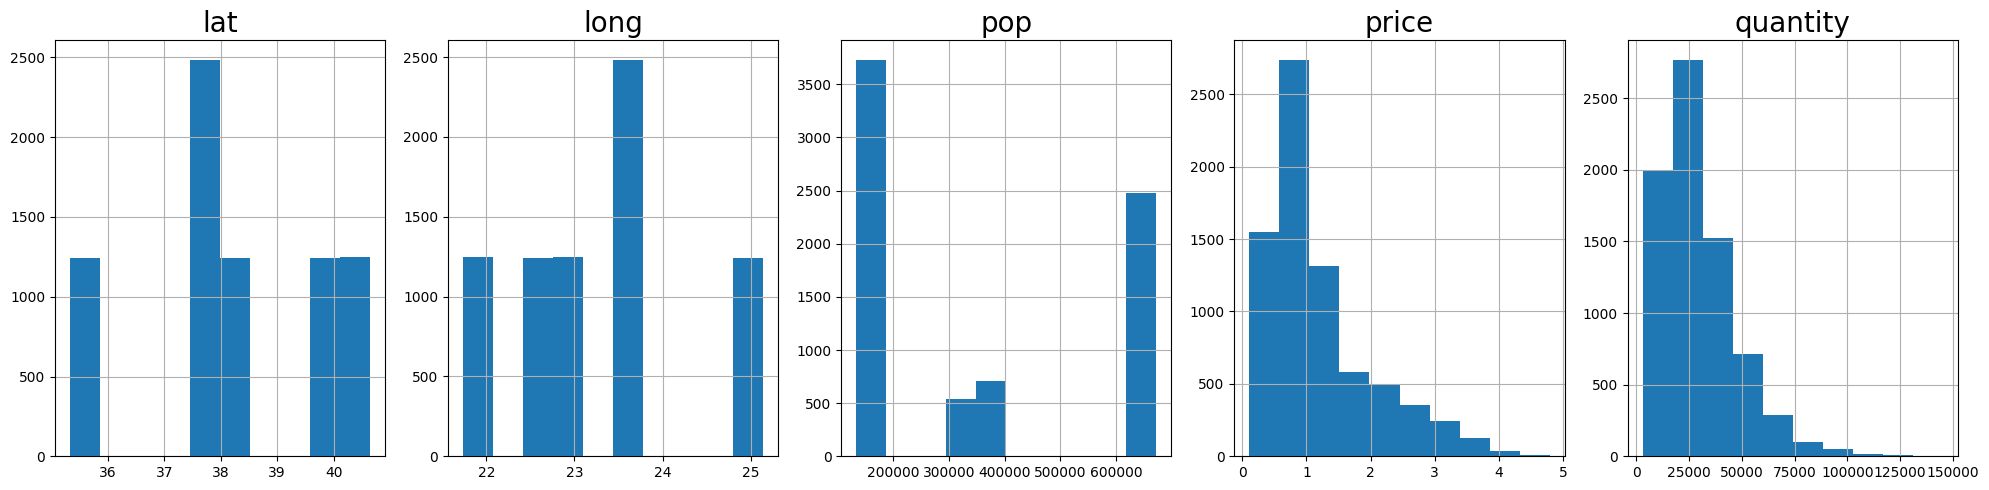

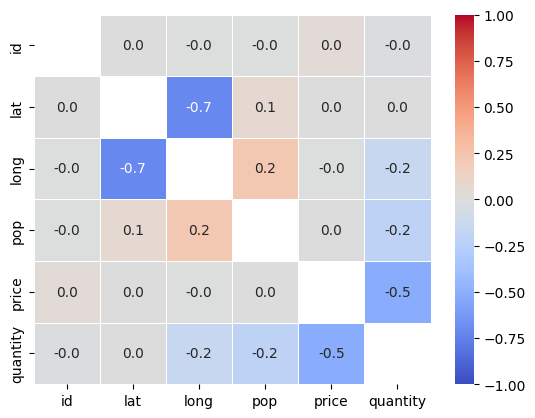

,count,unique,top,freq
city,7456,5,Athens,2482
shop,7456,6,shop_4,1246
brand,7456,5,kinder-cola,1495
container,7456,3,glass,2486
capacity,7456,3,330ml,2486


In [45]:
# EDA preliminar

# descripcion atributos numericos
display(df.describe().T)

# distribucion atributos numericos
plt.figure(figsize=(20,5))
plt.subplot(1,5,1)
df['lat'].hist()
plt.title('lat', fontsize=20)
plt.subplot(1,5,2)
df['long'].hist()
plt.title('long', fontsize=20)
plt.subplot(1,5,3)
df['pop'].hist()
plt.title('pop', fontsize=20)
plt.subplot(1,5,4)
df['price'].hist()
plt.title('price', fontsize=20)
plt.subplot(1,5,5)
df['quantity'].hist()
plt.title('quantity', fontsize=20)
plt.tight_layout()
plt.show() ;

# matriz de correlacion atributos numericos
mat = df.corr(numeric_only=True)
sns.heatmap(mat[mat!=1], annot=True, vmin=-1, vmax=1, fmt=".1f", linewidth=.5, cmap='coolwarm')
plt.show() ;

# descripcion atributos categoricos
display(df.describe(include=['O']).T)

In [46]:
# Inserte su código acá

# En virtud del EDA expuesto en el bloque de codigo anterior, se consideran como atributos numericos las columnas
# 'pop' y 'price', mientras que como atributos categoricos las columnas 'city', 'lat', 'pop', 'shop', 'brand', 
# 'container', 'capacity', 'day', 'month' y 'year', donde estas ultimas tres columnas se obtienen
# luego de aplicar el FunctionTransformer al dataset. 
# Cabe señalar que se descartan las columnas 'id' y 'long', pues, la primera constituye un atributo identificador,
# mientras que para la segunda se reconoce multicolinealidad con la columna 'lat'

# 1.
X = df.drop('quantity', axis=1)
y = df.quantity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-.7, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.1/(.1+.2), random_state=123) 

# 2.
def extract_from_date(dataframe_in) :
    dataframe_out = dataframe_in.copy()
    dataframe_out['day'] = dataframe_out['date'].dt.day.astype('category')
    dataframe_out['month'] = dataframe_out['date'].dt.month.astype('category')
    dataframe_out['year'] = dataframe_out['date'].dt.year.astype('category')
    dataframe_out = dataframe_out.drop('date', axis=1)
    return dataframe_out
ft = FunctionTransformer(extract_from_date)

# 3. 
# Para los atributos numericos, se aplica una transformacion logaritmica (dada la forma de la distribucion
# observada para la columna 'price') y, luego, un escalamiento MinMax
cat_cols = ['city', 'lat', 'pop', 'shop', 'brand', 'container', 'capacity', 'day', 'month', 'year']
num_cols = ['pop', 'price']
ct = ColumnTransformer(
    transformers=[
        ('cat_preprocess', OneHotEncoder(), cat_cols),
        ('num_preprocess', Pipeline(steps=[("num_preprocess1", FunctionTransformer(np.log10)),
                                           ('num_preprocess2', MinMaxScaler())]), num_cols)
    ], remainder='drop'
)

# 4.
pipe = Pipeline([('trf1', ft), ('trf2', ct), ('trf3', DummyRegressor(strategy='mean'))])

# 5.
model_1 = pipe.fit(X_train, y_train)
y_pred = model_1.predict(X_val)
mae_model_1 = mean_absolute_error(y_val, y_pred)
print(f'MAE DummyRegressor : {mae_model_1:.0f}')

# 6.
pipe = Pipeline([('trf1', ft), ('trf2', ct), ('trf3', XGBRegressor(seed=123))])
model_2 = pipe.fit(X_train, y_train)
y_pred = model_2.predict(X_val)
mae_model_2 = mean_absolute_error(y_val, y_pred)
print(f'MAE XGBRegressor : {mae_model_2:.0f}')

# 7.
pickle.dump(model_1, open('Lab_09/model_1.pkl', 'wb'))
pickle.dump(model_2, open('Lab_09/model_2.pkl', 'wb'))

MAE DummyRegressor : 13255
MAE XGBRegressor : 2643


En relación a las preguntas de esta sección:

> ¿Cómo se interpreta esta métrica para el contexto del negocio?

**R.** La métrica `mean_absolute_error` constituye una medida de la diferencia entre dos variables continuas, vale decir, la diferencia entre el `quantity` predicho por el modelo inicial `DummyRegressor` y el `quantity` observado en el conjunto de validación. Así, mientras mayor sea el valor de la métrica, menor será la precisión y/o desempeño del modelo implementado para la predicción de la variable objetivo.

> ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`?

**R.** Al implementar el algoritmo `XGBRegressor`, se observa una disminución sustancial del `mean_absolute_error` respecto a aquel obtenito con el modelo inicial `DummyRegressor` (*i.e.* una reducción de 13255 a 2643 unidades de producto), por lo cual, es posible sostener que `XGBRegressor` se desempeña mejor que `DummyRegressor` para la predicción de `quantity`.

## 1.2 Forzando relaciones entre parámetros con XGBoost (1.0 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo.

Vuelva a entrenar el `Pipeline`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo?

Nuevamente, guarde su modelo en un archivo .pkl

Nota: Para realizar esta parte, debe apoyarse en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>.

Hint: Para implementar el constraint, se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

In [47]:
# Inserte su código acá

# generamos la restriccion para el ultimo atributo (price)
constraint =  [0 for i in range(Pipeline([('trf1', ft), ('trf2', ct)]).fit_transform(X_train).shape[1])]
constraint[-1] = -1

# generamos pipeline y ajustamos el modelo
pipe = Pipeline([('trf1', ft), ('trf2', ct), ('trf3', XGBRegressor(seed=123, monotone_constraints=tuple(constraint)))])
model_3 = pipe.fit(X_train, y_train)
y_pred = model_3.predict(X_val)
mae_model_3 = mean_absolute_error(y_val, y_pred)
print(f'MAE XGBRegressor with Constraint: {mae_model_3:.0f}')

# guardamos el modelo
pickle.dump(model_3, open('Lab_09/model_3.pkl', 'wb'))

MAE XGBRegressor with Constraint: 2767


En relación a la pregunta de esta sección:

> ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo?

**R.** Al incluir la relación monótona negativa entre `price` y `quantity`, se observa un incremento del error de 124 unidades de producto respecto al algoritmo `XGBRegressor` con los parámetros por default (*i.e.* el `mean_absolute_error` aumenta de 2643 a 2767 unidades de producto). Así, podría sostenerse que el amigo no tenía razón, sin embargo, su información es parcialmente correcta puesto que, como se observa en la gráfica siguiente, sí existe una relación inversa entre el precio y la cantidad de producto, aunque la relación no es monótona, sino que se trata de una relación no lineal, por lo que, imponer la restricción monótona conduce a un modelo con menor precisión.

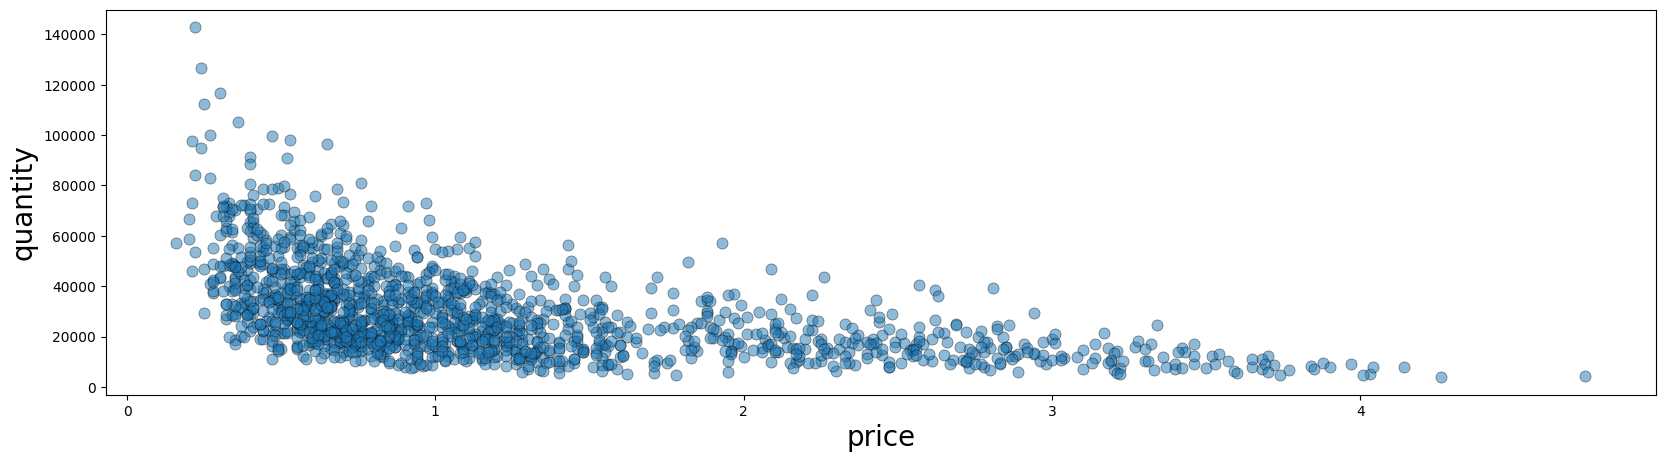

In [48]:
plt.figure(figsize=(20,5))
plt.plot(X_val.price, y_val, 'o', markersize=8, markeredgewidth=.5, markeredgecolor='black', alpha=.5)
plt.xlabel('price', fontsize=20)
plt.ylabel('quantity', fontsize=20)
plt.show() ;

## 1.3 Optimización de Hiperparámetros con Optuna (2.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se le pide:

- [X] Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- [X] Utilice `TPESampler` como método de muestreo
- [X] De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- [X] De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)
- [X] Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados?
- [X] Fije el tiempo de entrenamiento a 5 minutos
- [X] Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- [X] Guardar su modelo en un archivo .pkl

In [49]:
# Inserte su código acá

# definimos la funcion objetivo
def objective(trial):
    
    # definimos parametros a optimizar para XGBRegressor
    params_XGBRegressor = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    }
    
    # definimos parametros a optimizar para OneHotEncoder
    params_OneHotEncoder = {
        'min_frequency': trial.suggest_float('min_frequency', 1e-8, 1.0, log=True)
    }

    # generamos pipeline y ajustamos el modelo
    pipe = Pipeline([('trf1', ft), 
                     ('trf2', ColumnTransformer(
                         transformers=[
                             ('cat_preprocess', OneHotEncoder(**params_OneHotEncoder), cat_cols),
                             ('num_preprocess', Pipeline(steps=[("num_preprocess1", FunctionTransformer(np.log10)),
                                                                ('num_preprocess2', MinMaxScaler())]), num_cols)
                         ], remainder='drop')
                     ), 
                     ('trf3', XGBRegressor(seed=123, **params_XGBRegressor))])
    optuna_model = pipe.fit(X_train, y_train)

    # evaluamos las predicciones del modelo
    y_pred = optuna_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    
    return mae

# generamos estudio de optimizacion
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(sampler=TPESampler(seed=123), direction='minimize')
study.optimize(objective, timeout=5*60, show_progress_bar=True)

# reporte de resultados
print('Número de trials: {}'.format(len(study.trials)))
print()
print('Mejor trial:')
trial = study.best_trial
print()
print(f'- MAE = {trial.value:.0f}')
print()
print('- Params: ')
for key, value in trial.params.items():
    print(f'    {key:18.18s} = {value}')
    
# guardamos el modelo
params = study.best_params
params_OneHotEncoder = params.popitem()
params_OneHotEncoder = {params_OneHotEncoder[0]: params_OneHotEncoder[1]}
params_XGBRegressor = params
pipe = Pipeline([('trf1', ft), 
                 ('trf2', ColumnTransformer(
                     transformers=[
                         ('cat_preprocess', OneHotEncoder(**params_OneHotEncoder), cat_cols),
                         ('num_preprocess', Pipeline(steps=[("num_preprocess1", FunctionTransformer(np.log10)),
                                                            ('num_preprocess2', MinMaxScaler())]), num_cols)
                     ], remainder='drop')
                 ), 
                 ('trf3', XGBRegressor(**params_XGBRegressor))])
model_4 = pipe.fit(X_train, y_train)
pickle.dump(model_4, open('Lab_09/model_4.pkl', 'wb'))

Best trial: 288. Best value: 2050.1:  100%|██████████| 05:00/05:00 


Número de trials: 293

Mejor trial:

- MAE = 2050

- Params: 
    learning_rate      = 0.08415095986329704
    n_estimators       = 828
    max_depth          = 7
    max_leaves         = 72
    min_child_weight   = 5
    reg_alpha          = 0.23578117266558885
    reg_lambda         = 0.00040964650644359
    min_frequency      = 0.05763676612268369


En relación a las preguntas de esta sección:

> Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados?

**R.** Los parámetros optimizados a través del paquete `optuna` fueron los siguientes:

- `learning_rate`. Tasa de aprendizaje para la reducción del tamaño de paso que se utiliza en la actualización, permitiendo prevenir *overfitting*.


- `n_estimators`. Número de árboles impulsados por gradiente, permitiendo controlar el rendimiento y estabilidad numérica del modelo durante el entrenamiento.


- `max_depth`. Profundidad máxima de un árbol para los componentes base de aprendizaje, permitiendo controlar el rendimiento del modelo durante el entrenamiento.


- `max_leaves`. Número máximo de ramas en un árbol, permitiendo controlar el rendimiento del modelo durante el entrenamiento.


- `min_child_weight`. Número mínimo de instancias necesarias para cada nodo de un árbol, permitiendo controlar cuán conservador es el algoritmo.


- `reg_alpha`. Término de regularización L1 sobre los pesos, permitiendo prevenir *overfitting*.


- `reg_lambda`. Término de regularización L2 sobre los pesos, permitiendo prevenir *overfitting*.


- `min_frequency`. Frecuencia mínima por debajo de la cual una categoría dada se considera poco frecuente, permitiendo descartarla en caso existan.

En términos generales, se considera que los rangos de optimización sugeridos son pertinentes para el problema en estudio, resultando que, luego del proceso de optimización, todos los hiperparámetros evaluados se encuentran dentro de dichos rangos, excepto por `max_depth`, para el cual se podría incrementar el rango de búsqueda debido a que el valor optimizado se encuentra en el límite superior.

> ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?

**R.** Al optimizar los hiperparámetros del algoritmo `XGBRegressor`, además de uno de los hiperparámetros de `OneHotEncoder`, se observa una disminución del error de 710 unidades de producto respecto al algoritmo `XGBRegressor` forzado con una relación monótona negativa (*i.e.* el `mean_absolute_error` disminuye de 2767 a 2057 unidades de producto). Dicho resultado se produce, entre otras razones, porque la optimización de hiperparámetros permite reducir el *overfitting*, mejorar el preprocesamiento/transformación de los atributos predictores y acelerar la convergencia del algoritmo en el modelo implementado.

## 1.4 Optimización de Hiperparámetros con Optuna y Prunners (1.7)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- [X] Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento?
- [X] Utilizar `optuna.integration.XGBoostPruningCallback` como método de **Prunning**
- [X] Fijar nuevamente el tiempo de entrenamiento a 5 minutos
- [X] Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- [X] Guardar su modelo en un archivo .pkl

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [50]:
# Inserte su código acá

# definimos la funcion objetivo
def objective(trial):
    
    # definimos parametros a optimizar para XGBRegressor
    params_XGBRegressor = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'eval_metric': 'rmse'
    }
    
    # definimos parametros a optimizar para OneHotEncoder
    params_OneHotEncoder = {
        'min_frequency': trial.suggest_float('min_frequency', 1e-8, 1.0, log=True)
    }
    
    # generamos pipeline y ajustamos el modelo
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-rmse')
    pipe = Pipeline([('trf1', ft), 
                     ('trf2', ColumnTransformer(
                         transformers=[
                             ('cat_preprocess', OneHotEncoder(**params_OneHotEncoder), cat_cols),
                             ('num_preprocess', Pipeline(steps=[("num_preprocess1", FunctionTransformer(np.log10)),
                                                                ('num_preprocess2', MinMaxScaler())]), num_cols)
                         ], remainder='drop')
                     ), 
                     ('trf3', XGBRegressor(**params_XGBRegressor, callbacks=[pruning_callback]))])

    # pipeline de preprocesamiento para conjunto de validación  
    preprocessing_pipeline = Pipeline([
        ('trf1', ft),
        ('trf2', ColumnTransformer(
            transformers=[('cat_preprocess', OneHotEncoder(**params_OneHotEncoder), cat_cols),
                        ('num_preprocess', Pipeline(steps=[("num_preprocess1", FunctionTransformer(np.log10)),
                                                            ('num_preprocess2', MinMaxScaler())]), num_cols)], remainder='drop'))
                                                            ])

    # se ajusta el pipeline de preprocesamiento con los datos de entrenamiento
    preprocessing_pipeline.fit(X_train, y_train)

    # se transforma el conjunto de validación
    X_val_transformed = preprocessing_pipeline.transform(X_val)

    # Entrenamos el modelo con el conjunto de validación transformado
    optuna_model = pipe.fit(X_train, y_train, trf3__eval_set=[(X_val_transformed, y_val)], trf3__verbose=False)
    #print(optuna_model.named_steps['trf3'].evals_result())

    
    # Evaluamos las predicciones del modelo
    y_pred = optuna_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
        
    return mae

# generamos estudio de optimizacion
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(sampler=TPESampler(seed=123), direction='minimize')
study.optimize(objective, timeout=5*60, show_progress_bar=True)

# reporte de resultados
print('Número de trials: {}'.format(len(study.trials)))
print()
print('Mejor trial:')
trial = study.best_trial
print()
print(f'- MAE = {trial.value:.0f}')
print()
print('- Params: ')
for key, value in trial.params.items():
    print(f'    {key:18.18s} = {value}')

# guardamos el modelo
params = study.best_params
params_OneHotEncoder = params.popitem()
params_OneHotEncoder = {params_OneHotEncoder[0]: params_OneHotEncoder[1]}
params_XGBRegressor = params
pipe = Pipeline([('trf1', ft), 
                 ('trf2', ColumnTransformer(
                     transformers=[
                         ('cat_preprocess', OneHotEncoder(**params_OneHotEncoder), cat_cols),
                         ('num_preprocess', Pipeline(steps=[("num_preprocess1", FunctionTransformer(np.log10)),
                                                            ('num_preprocess2', MinMaxScaler())]), num_cols)
                     ], remainder='drop')
                 ), 
                 ('trf3', XGBRegressor(**params_XGBRegressor))])
model_5 = pipe.fit(X_train, y_train)
pickle.dump(model_5, open('Lab_09/model_5.pkl', 'wb'))

Best trial: 198. Best value: 2110.97:  100%|██████████| 05:00/05:00


Número de trials: 612

Mejor trial:

- MAE = 2111

- Params: 
    learning_rate      = 0.09914383295694433
    n_estimators       = 826
    max_depth          = 10
    max_leaves         = 80
    min_child_weight   = 5
    reg_alpha          = 0.03450071860187535
    reg_lambda         = 2.773667347179218e-08
    min_frequency      = 0.00031683928998590255


En relación a las preguntas de esta sección:

> ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento?

**R.** El prunning es una técnica de machine learning que consiste en disminuir los recursos destinados a entrenar modelos, terminando prematuramente el entrenamiento de aquellos que no muestren un buen desempeño temprano. Esto lleva a un entrenamiento más rápido y eficaz, lo que permite una mayor exploración del espacio de hiperparámetros en el mismo tiempo y con los mismos recursos.

> Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?

**R.** Lo primero que se observa es que, en los mismos cinco minutos, se alcanzan a completar más del doble de trials usando pruning. Respecto al desempeño, el MAE es ligeramente mayor al obtenido en la sección anterior (2111 vs 2057), aun cuando el uso de pruning permitió realizar más del doble de trials que en la sección anterior. Lo anterior se puede explicar en que pruning termina prematuramente el entrenamiento de modelos poco prometedores.

Respecto a los parámetros obtenidos, las mayores diferencias se observan en los parámetros de regularización L1 y L2. En el caso de pruning, la regularización resulta ser menos estricta que en el modelo anterior. Posiblemente esto se explica en que, como pruning detiene prematuramente el entrenamiento de modelos que no muestran un buen desempeño temprano, sería posible probar con una regularización menos estricta ya que el término temprano del entrenamiento de modelos subóptimos también contribuye a prevenir el *overfitting*, lo cual permite explorar modelos más flexibles en términos de regularización obteniendo un desempeño similar.

## 1.5 Visualizaciones (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

- Gráfico de historial de optimización
- Gráfico de coordenadas paralelas
- Gráfico de importancia de hiperparámetros

Comente sus resultados: ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo?

In [51]:
# Gráfico de historial de optimización
plot_optimization_history(study)

In [52]:
# Gráfico de coordenadas paralelas
plot_parallel_coordinate(study)

In [53]:
#  Gráfico de importancia de hiperparámetros
plot_param_importances(study)

En relación a las preguntas de esta sección:

> ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados?

**R.** Desde el trial N°10 se empiezan a observar mejoras notables en los resultados, manteniéndose en torno a un `mean_absolute_error` de aproximadamente 2000 unidades de producto hasta el final del proceso de optimización.

> ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas?

**R.** En virtud de la gráfica, se reconoce que los valores mínimos de `mean_absolute_error` se asocian a valores de `learning_rate`, `max_depth` y `reg_alpha` en el límite superior del rango de optimización, mientras que, a su vez, también se asocia a valores de `min_frequency` en el límite inferior. Para el resto de los hiperparámetros, no se distinguen patrones claros para establecer asociaciones con `mean_absolute_error`.

> ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo?

**R.** El hiperparámetro de mayor importancia corresponde a `min_frequency`, seguido por `max_leaves`, `learning_rate`, y `n_estimators`, resultando que el resto de los hiperparámetros pueden considerarse con una importancia baja a nula para la optimización del modelo `XGBRegressor`.

## 1.6 Síntesis de resultados (0.3)

Finalmente, genere una tabla resumen del MAE obtenido en los 5 modelos entrenados (desde Baseline hasta XGBoost con Constraints, Optuna y Prunning) y compare sus resultados. ¿Qué modelo obtiene el mejor rendimiento? 

Por último, cargue el mejor modelo, prediga sobre el conjunto de test y reporte su MAE. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto?

In [54]:
# resultados modelo 1
model_1 = pickle.load(open('Lab_09/model_1.pkl', 'rb'))
mae_model_1 = mean_absolute_error(y_val, model_1.predict(X_val))

# resultados modelo 2
model_2 = pickle.load(open('Lab_09/model_2.pkl', 'rb'))
mae_model_2 = mean_absolute_error(y_val, model_2.predict(X_val))

# resultados modelo 3
model_3 = pickle.load(open('Lab_09/model_3.pkl', 'rb'))
mae_model_3 = mean_absolute_error(y_val, model_3.predict(X_val))

# resultados modelo 4
model_4 = pickle.load(open('Lab_09/model_4.pkl', 'rb'))
mae_model_4 = mean_absolute_error(y_val, model_4.predict(X_val))

# resultados modelo 5
model_5 = pickle.load(open('Lab_09/model_5.pkl', 'rb'))
mae_model_5 = mean_absolute_error(y_val, model_5.predict(X_val))

# resumen de resultados
summary = pd.DataFrame({'Baseline':[mae_model_1], 
                        'XGBoost default':[mae_model_2], 
                        'XGBoost with Constraints':[mae_model_3], 
                        'XGBoost with Optuna':[mae_model_4], 
                        'XGBoost with Prunning':[mae_model_5]
                       }).T
summary.columns = ['MAE']
summary.MAE = summary.MAE.astype('int64')
summary

,MAE
Baseline,13254
XGBoost default,2643
XGBoost with Constraints,2767
XGBoost with Optuna,2050
XGBoost with Prunning,2110


In [55]:
y_pred = model_4.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE best model : {mae:.0f}')

MAE best model : 2120


En relación a las preguntas de esta sección:

> ¿Qué modelo obtiene el mejor rendimiento? 

**R.** El modelo que obtiene el mejor rendimiento corresponde a XGBoost con Prunning, resultando un `mean_absolute_error` de 2056 unidades de producto.

> ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto?

**R.**  Si bien se observa una diferencia del `mean_absolute_error` en el conjunto de test respecto a aquel obtenido en el conjunto de validación, esta puede considerarse mínima, por lo cual, es posible sostener que el modelo XGBoost con Prunning posee una capacidad de generalización satisfactoria. Ahora bien, cabe señalar que dicha diferencia se debe a que las predicciones se realizan sobre un conjunto que el modelo entrenado "nunca ha visto", adquiriendo importancia, en este sentido, el fenómeno de *overfitting* en la habilidad del modelo para generalizar sobre información nueva.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>